# Practical work 4: Frequency filtering, color


## Binôme : 
- Amine YOUCEF KHODJA 
- Amayas SADI

In [32]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image

def imshow(I,title=None,size=500,axis=None):
    """ display an image with a specific size """
    
    if axis == None:
        plt.figure(figsize=(size//80,size//80))
        plt.gray()
        plt.imshow(I)
        if title: plt.title(title)
        plt.show()
        return

    axis.imshow(I)
    if title: axis.set_title(title)

    
def toVisualizeLogFT(If):
    return np.log( 1 + np.abs(If))

def distance(X, Y):
    return np.sqrt(np.sum((X - Y) ** 2))


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

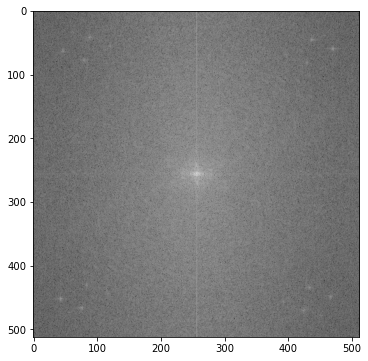

In [33]:
mandrill = np.array(Image.open('img/mandrill.png'))
mandrill_centred = fftshift(toVisualizeLogFT(fft2(mandrill)))
imshow(mandrill_centred)

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

In [34]:
def idealLowPassFilter(n, m, fc):
    H = np.zeros((n, m))
    centre = np.array([n//2, m//2])
    
    for i in range(n):
        for j in range(m):
            if distance(centre, np.array([i, j])) <= fc:
                H[i][j] = 1
                
    return H

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (use function `ifft2()` from module `numpy.fft`)
 - return the real part of filtered image

In [35]:
def lowPass(I, fc):
    FT_centred = fftshift(fft2(I))
    n, m = I.shape
    
    low_pass_id = idealLowPassFilter(n, m, fc)
    
    FT_filtred = FT_centred * low_pass_id
    FT_inv = ifft2(FT_filtred)
    
    return np.abs(FT_inv)

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


- Quand la frequence de coupure diminue le filter passe-bas garde moins de frequences sur le spectre original ce qui induit vers une perte de details sur l'image d'origine (contoure,  textures .. )
- Applications
    - Floutter des images : En prenant un seuil de coupure petit mais different de 0 quand meme . 
    - Augmenter la netteté d'une image  : En prenant un seuil tres grand ainsi garder plus de frequences hautes ce qui implique des details de plus sur l'image original.

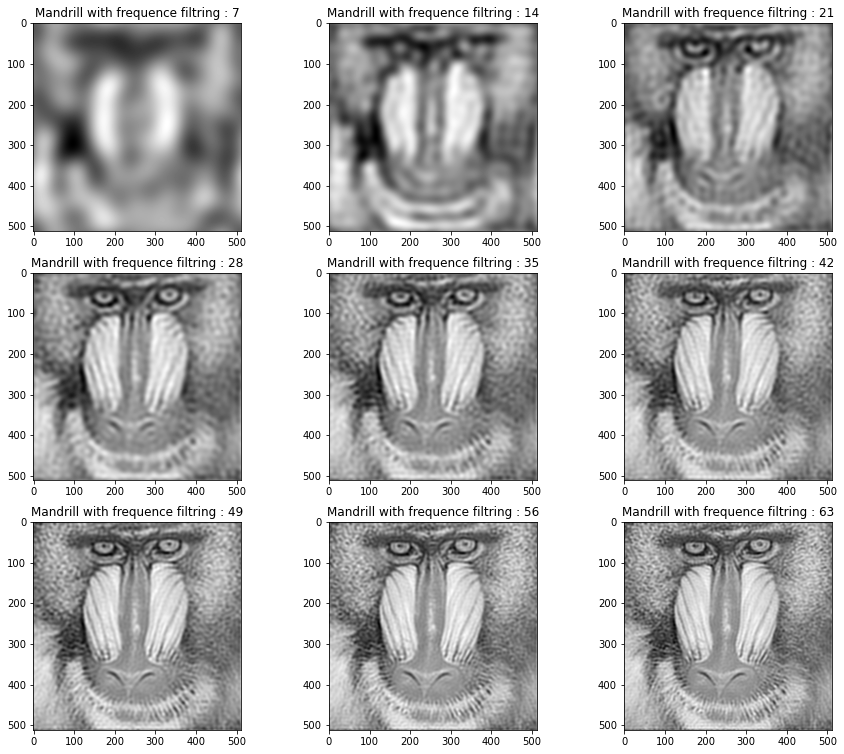

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15, 13))

for i in range(0, 9):
    f = 7 * (i+1)
    imshow(lowPass(mandrill,f), title=f"Mandrill with frequence filtring : {f}", axis=axs[i//3, i%3])

plt.show()

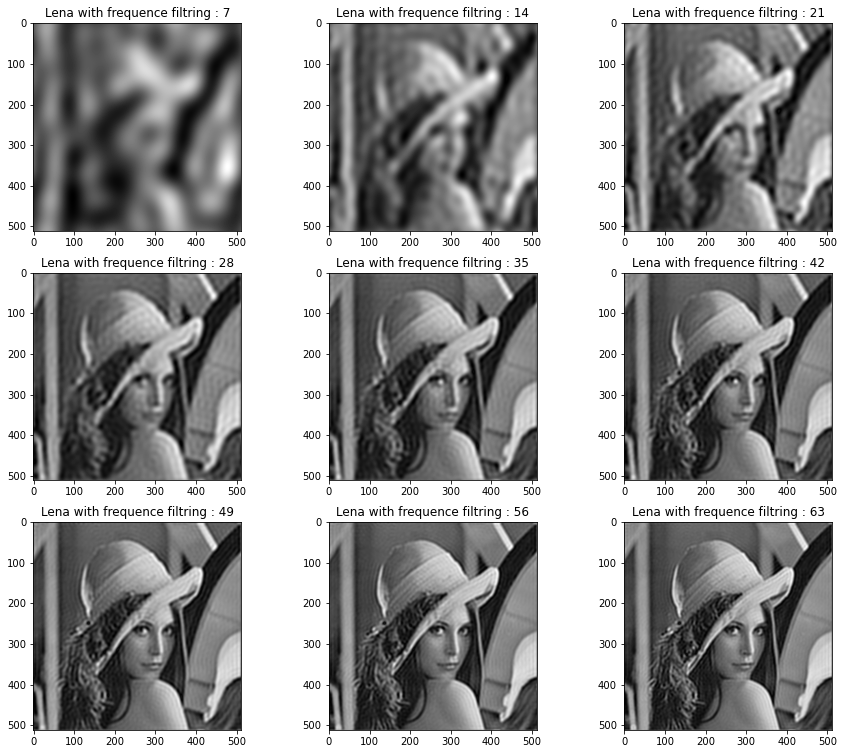

In [37]:
lena = np.array(Image.open('img/lena.jpg'))
fig, axs = plt.subplots(3, 3, figsize=(15, 13))

for i in range(0, 9):
    f = 7 * (i+1)
    imshow(lowPass(lena,f), title=f"Lena with frequence filtring : {f}", axis=axs[i//3, i%3])
    
plt.show()

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

- On ajoute $\lfloor d/2 \rfloor$ lignes et colonnes pour l'image

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [38]:
def imagePad(I, h):
    d, _ = h.shape
    d_2 = d // 2
    n, m = I.shape
    
    zeros = np.zeros((n, d_2))
    
    I = np.hstack((zeros, I, zeros))
    
    zeros = np.zeros((d_2, m + 2 * d_2))

    
    I = np.vstack((zeros, I, zeros))

    if d % 2 == 0:
        return I[:-1, :-1]
    
    return I

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [39]:
def d_inverse(H):
    n, m = H.shape
    H_inv = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            H_inv[i, j] = H[n - i - 1][m - j - 1]
    
    return H_inv

In [40]:
def conv2(I, h):
    d, _ = h.shape
    d_2 = d//2
    n, m = I.shape
    
    h = d_inverse(h)
    
    I = imagePad(I, h)
    
    Ic = np.zeros((n, m))
    
    n, m = I.shape
    for i in range(d_2, n - d_2):
        for j in range(d_2, m - d_2):

            if d % 2 == 1:
                P = I[i - d_2: i + d_2 + 1, j - d_2:j + d_2 + 1]
            else:
                P = I[i - d_2: i + d_2, j - d_2:j + d_2]
                                     
            Ic[i - d_2, j - d_2] = np.floor(np.sum(h * P))
            
    return Ic

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

- En augmentant la taille du filtre moyenneur appliqué à l'image orignale , sa fonction transfert tendera vers une dirac ce qui va laisser passer moins de frequences ce qui va induire vers une perte de details sur l'image . 

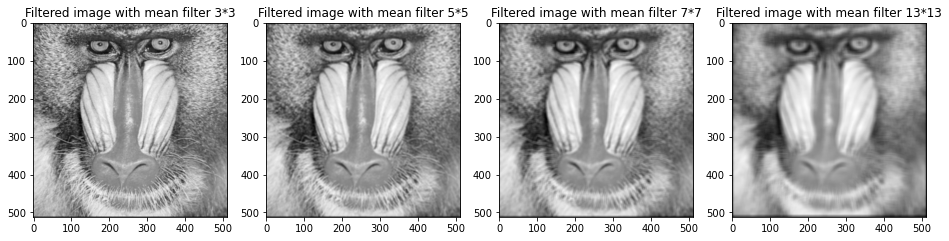

In [41]:
plt.figure(figsize=(16,9))

f_dim = 3
h_9 = 1/(f_dim*f_dim) * np.ones((f_dim, f_dim))
fl_mean_3_3 = conv2(mandrill, h_9)
plt.subplot(141)
plt.title("Filtered image with mean filter 3*3")
plt.imshow(fl_mean_3_3)

f_dim = 5
h_25 = 1/(f_dim*f_dim) * np.ones((f_dim, f_dim))
fl_mean_5_5 = conv2(mandrill, h_25)
plt.subplot(142)
plt.title("Filtered image with mean filter 5*5")
plt.imshow(fl_mean_5_5)

f_dim = 7
h_49 = 1/(f_dim*f_dim) * np.ones((f_dim, f_dim))
fl_mean_7_7 = conv2(mandrill, h_49)
plt.subplot(143)
plt.title("Filtered image with mean filter 7*7")
plt.imshow(fl_mean_7_7)

f_dim = 13
h_169 = 1/(f_dim*f_dim) * np.ones((f_dim, f_dim))
fl_mean_13_13 = conv2(mandrill, h_169)
plt.subplot(144)
plt.title("Filtered image with mean filter 13*13")
plt.imshow(fl_mean_13_13)


5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

In [42]:
def transfert(h):
    h = imagePad(h, np.zeros((256, 256)))
    return toVisualizeLogFT(fftshift(fft2(h)))

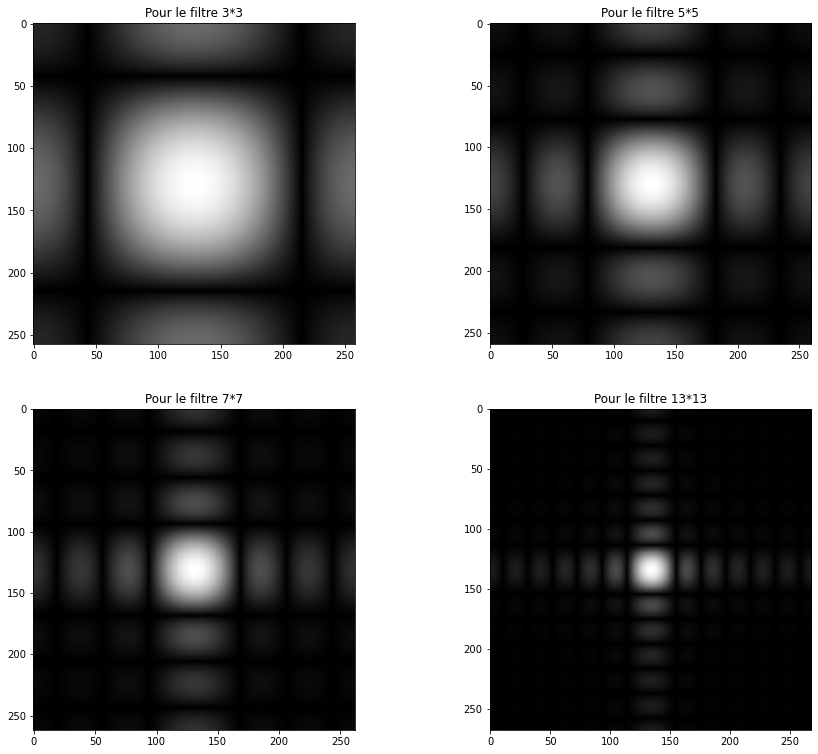

In [43]:
hs = [h_9, h_25, h_49, h_169]
titles = ["3*3", "5*5", "7*7", "13*13"]

fig, axs = plt.subplots(2, 2, figsize=(15, 13))

for i in range(len(hs)):
    imshow(transfert(hs[i]), title=f"Pour le filtre {titles[i]}", axis=axs[i//2, i%2])

6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

- La fonction de transfert du filtre moyenneur est un sinus cardinal (sinc) 
- C'est un filtre passe-bas non ideal car on voit l'exsitence de  valeurs entre 0 et 1 sur la fonction de transfert H.

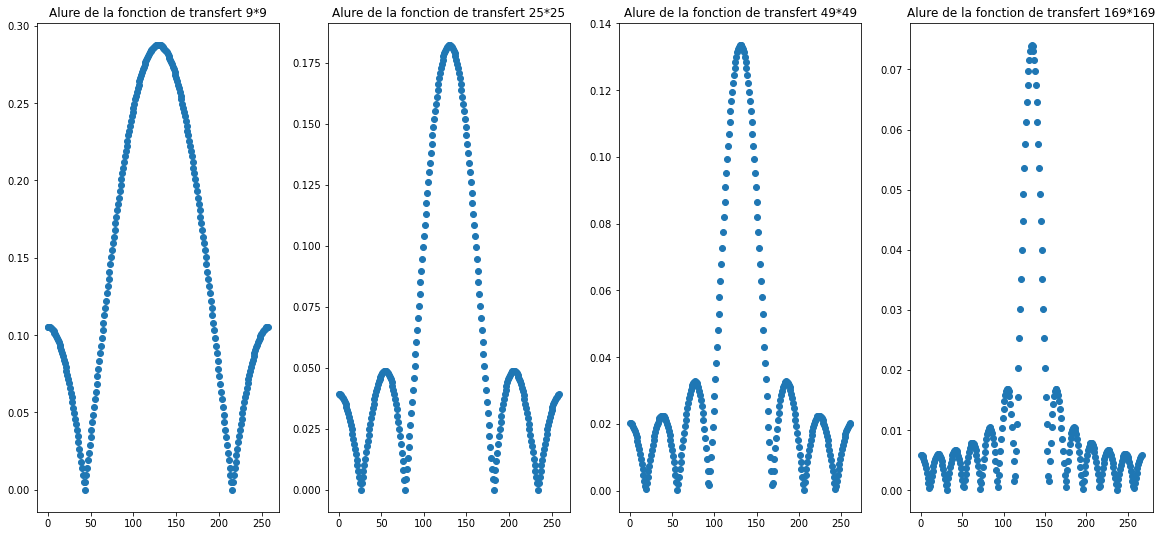

In [44]:
plt.figure(figsize=(20,9))

h_9_pad = imagePad(h_9, np.zeros((256, 256)))
h_9_spc = toVisualizeLogFT(fftshift(fft2(h_9_pad)))
plt.subplot(141)
plt.title("Alure de la fonction de transfert 9*9")
plt.scatter(np.arange(h_9_spc.shape[1]),h_9_spc[:,0])

h_25_pad = imagePad(h_25, np.zeros((256, 256)))
h_25_spc = toVisualizeLogFT(fftshift(fft2(h_25_pad)))
plt.subplot(142)
plt.title("Alure de la fonction de transfert 25*25")
plt.scatter(np.arange(h_25_spc.shape[1]),h_25_spc[:,0])

h_49_pad = imagePad(h_49, np.zeros((256, 256)))
h_49_spc = toVisualizeLogFT(fftshift(fft2(h_49_pad)))
plt.subplot(143)
plt.title("Alure de la fonction de transfert 49*49")
plt.scatter(np.arange(h_49_spc.shape[1]),h_49_spc[:,0])

h_169_pad = imagePad(h_169, np.zeros((256, 256)))
h_169_spc = toVisualizeLogFT(fftshift(fft2(h_169_pad)))
plt.subplot(144)
plt.title("Alure de la fonction de transfert 169*169")
plt.scatter(np.arange(h_169_spc.shape[1]),h_169_spc[:,0])

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

- Pour trouver la taille : (d,d) --> d = 2 $\lfloor 3*\sigma \rfloor$ + 1 
    - (3,3) par exemple : $\sigma$ = 0.3 car 2x(3x0.3) +1 = 2*1 + 1 = 3

In [45]:
def gaussianKernel(sigma):
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

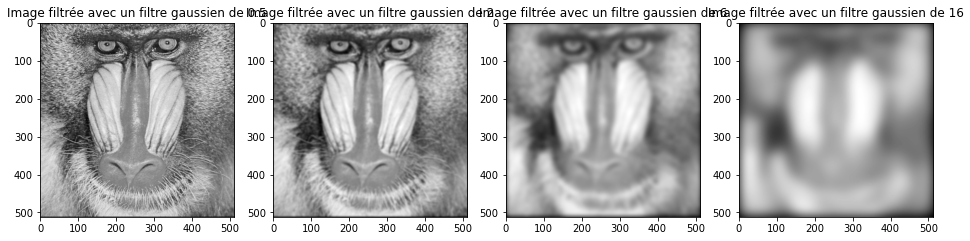

In [46]:
plt.figure(figsize=(16,9))

h_05 = gaussianKernel(0.5)
fl_gauss_05 = conv2(mandrill, h_05)
plt.subplot(141)
plt.title("Image filtrée avec un filtre gaussien de 0.5")
plt.imshow(fl_gauss_05)

h_2 = gaussianKernel(2)
fl_gauss_2 = conv2(mandrill, h_2)
plt.subplot(142)
plt.title("Image filtrée avec un filtre gaussien de 2")
plt.imshow(fl_gauss_2)

h_6 = gaussianKernel(6)
fl_gauss_6 = conv2(mandrill, h_6)
plt.subplot(143)
plt.title("Image filtrée avec un filtre gaussien de 6")
plt.imshow(fl_gauss_6)


h_16 = gaussianKernel(16)
fl_gauss_16 = conv2(mandrill, h_16)
plt.subplot(144)
plt.title("Image filtrée avec un filtre gaussien de 16")
plt.imshow(fl_gauss_16)


## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

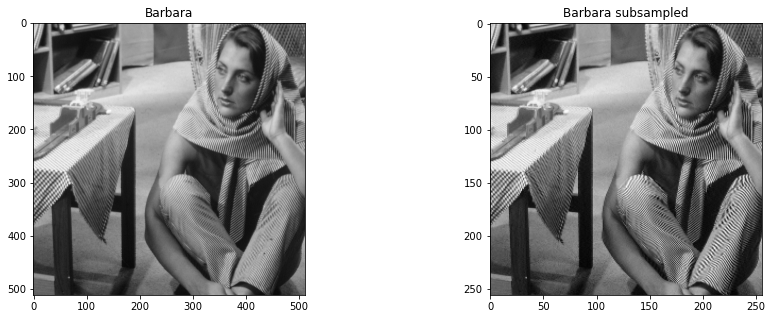

In [47]:
def subSample2(I):
    return I[::2,::2]

barbara = np.array(Image.open("img/barbara.png"))
barbara_subsampled = subSample2(barbara)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

imshow(barbara, title="Barbara", axis=axs[0])
imshow(barbara_subsampled, title="Barbara subsampled", axis=axs[1])

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

In [48]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A

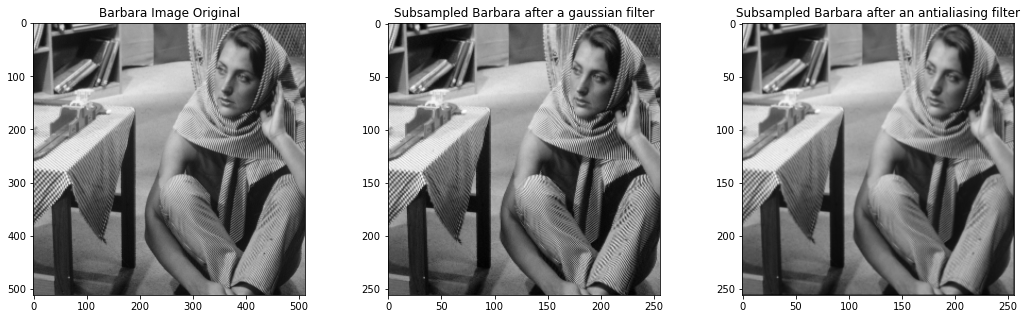

In [49]:
barbara_subsampled = subSample2(barbara)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

imshow(barbara, title="Barbara Image Original", axis=axs[0])

h_05 = gaussianKernel(0.5)
fl_gauss_05 = conv2(barbara, h_05)
fl_gauss_05_subsam = subSample2(fl_gauss_05)
imshow(fl_gauss_05_subsam, title="Subsampled Barbara after a gaussian filter", axis=axs[1])


h = antiAliasingFilter(7,7)
fl_antialia_07 = conv2(barbara, h)
fl_antialia_07_subsam = subSample2(fl_antialia_07)
imshow(fl_antialia_07_subsam, title="Subsampled Barbara after an antialiasing filter", axis=axs[2])

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

En sous-echantillionnant une image deja filtré par un filtre gaussien ( ou moyenneur ) l'effet de l'aliasing apparait quand meme . Contrairement a l'image sous-echantionnée apres un filtre anti-aliasing dont lequelle l'aliasing n'apparait pas et on retrouve l'image original ainsi .
#### Explication :
le filtre anti-aliasing elimine les hautes fréquences et laisse passer les basses frequences apropriées au parametre voulu . Parmi les hautes frequences eliminées par le filtre : les frequences(celles superieurs a la moitié de la frequence maximale) dont le sous-echantionnage est censé eliminé ainsi le sous-echantionnage apres ce filtre aura aucun effet sur l'image apres le filtre .

Contrairement au filtre gaussien qui n'elimine pas necessairement les frequences superieurs à la moitié de la frequence maximale ( sauf si on prend un $\sigma$ calculé pour ca ) c'est pour cela que l'aliasing apparait apres sous-echantionnage de l'image auquelle on a appliqué le filtre gaussien .

## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

- Image 01 : Image colorée ou chaque pour pixel on a une valeur de (r,b,g) representant des valeurs sur des niveaux de couleurs (rouge,bleu,vert)
- Image 02 : Image en noir et blanc ou chaque pixel a une valeur dans le niveau de gris

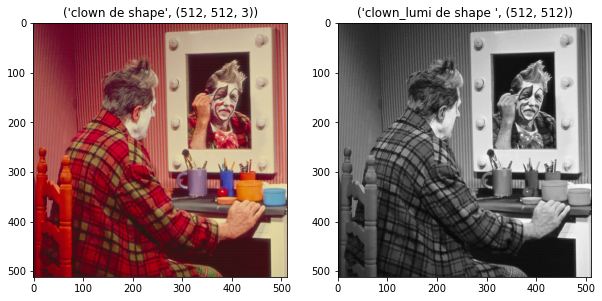

In [50]:
I1 = np.array(Image.open("img/clown.bmp"))
I2 = np.array(Image.open("img/clown_lumi.bmp"))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

titre = "clown de shape",I1.shape
imshow(I1, title=titre, axis=axs[0])

titre = "clown_lumi de shape ",I2.shape
imshow(I2, title=titre, axis=axs[1])

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

- Chaque dimension parmi les trois represente un niveau de couleur different qui va correspondre à des frequences differentes dans le spectre associé a cette image 

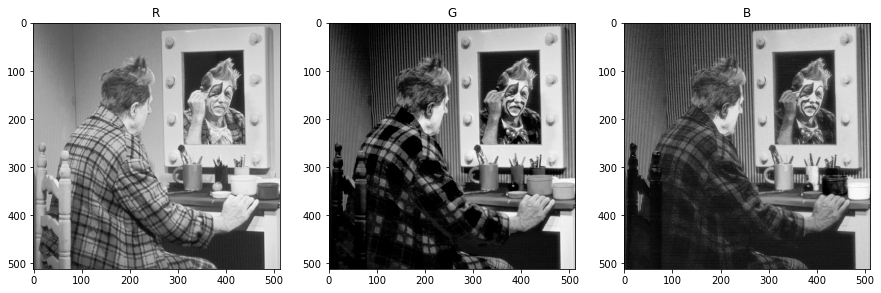

In [51]:
Ir, Ig, Ib = I1[:, :, 0], I1[:, :, 1], I1[:, :, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

imshow(Ir, title="R", axis=axs[0])
imshow(Ig, title="G", axis=axs[1])
imshow(Ib, title="B", axis=axs[2])

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

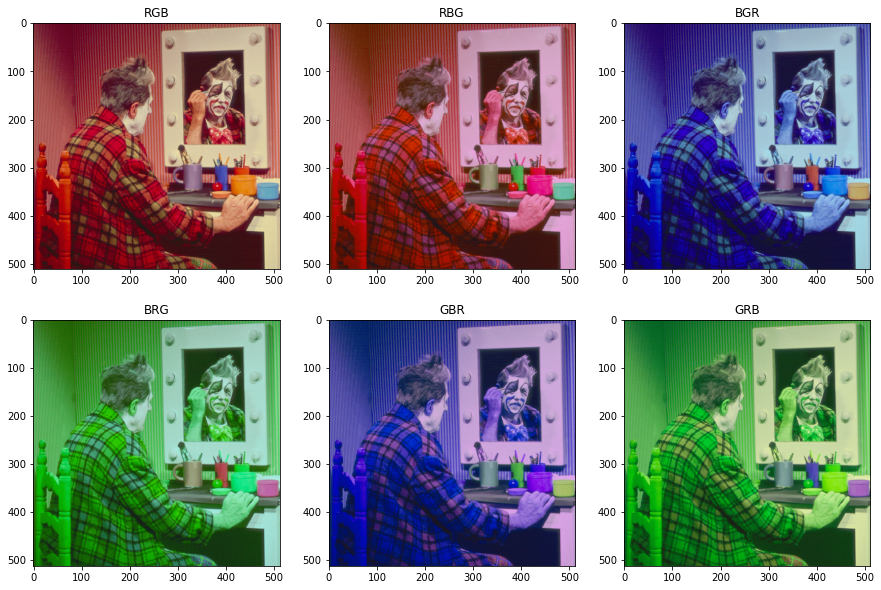

In [52]:
I3 = np.stack((Ir, Ib, Ig), axis=2) / 255
I4 = np.stack((Ib, Ig, Ir), axis=2) / 255
I5 = np.stack((Ib, Ir, Ig), axis=2) / 255
I6 = np.stack((Ig, Ib, Ir), axis=2) / 255
I7 = np.stack((Ig, Ir, Ib), axis=2) / 255

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


imshow(I1, title="RGB", axis=axs[0, 0])
imshow(I3, title="RBG", axis=axs[0, 1])
imshow(I4, title="BGR", axis=axs[0, 2])
imshow(I5, title="BRG", axis=axs[1, 0])
imshow(I6, title="GBR", axis=axs[1, 1])
imshow(I7, title="GRB", axis=axs[1, 2])

4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

In [53]:
def image_scales_rgb(Image):
    Ir, Ig, Ib = Image[:, :, 0], Image[:, :, 1], Image[:, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))

    imshow(Ir, title="R", axis=axs[0])
    imshow(Ig, title="G", axis=axs[1])
    imshow(Ib, title="B", axis=axs[2])

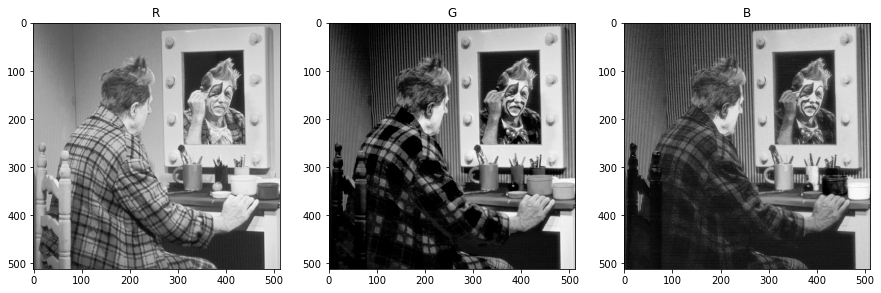

In [54]:
image_scales_rgb(I1)

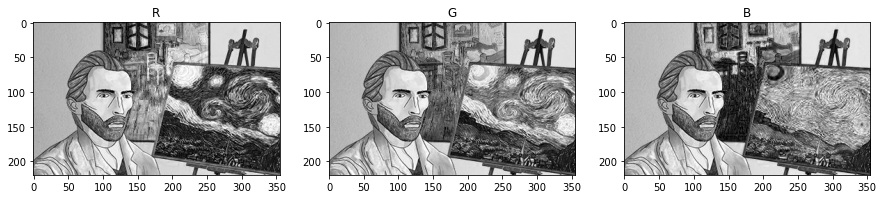

In [55]:
artist = np.array(Image.open("img/artist.jpg"))
image_scales_rgb(artist)

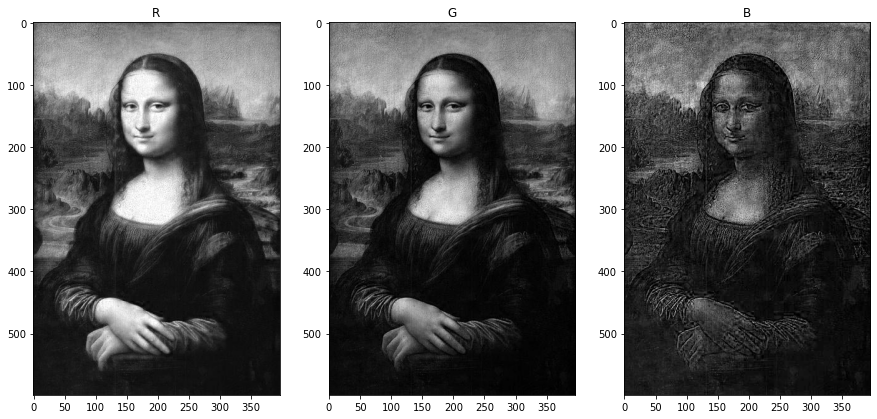

In [56]:
monalisa = np.array(Image.open("img/monalisa.jpg"))
image_scales_rgb(monalisa)